# [Sequence To Sequence](https://wikidocs.net/24996)

seq2seq는 번역기에서 대표적으로 사용되는 모델입니다.

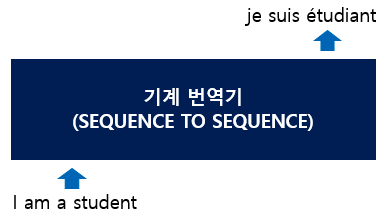

## Encoder
1. 인코더의 은닉 상태를 적절한 값(ex. 영벡터)으로 초기화한다.
2. 매 시점(time step)원문의 단어(token)가 입력되면(단어의 임베딩이 입력되면) 인코더는 이를 이용해 은닉 상태를 업데이트를 한다.
3. 입력 시퀀스의 끝까지 이 과정을 반복하면 인코더의 최종 은닉 상태는 입력 시퀀스의 정보를 압축 요약한 정보를 담고 있게 된다.
4. 이 마지막 시점에서의 인코더 은닉 상태를 컨텍스트 벡터라고 하고, 이 값은 디코더로 넘어간다.

## Decoder
1. 디코더는 전달받은 컨텍스트 벡터로 자신의 은닉 상태를 초기화한다.
2. 그리고 매 시점 자신이 바로 직전 시점에 출력했던 단어를 입력으로 받아, 자신의 은닉 상태를 업데이트하고, 이를 이용해 다음 단어를 예측한다. (최초 시점에서는 시퀀스 시작을 의미하는 `<sos>` 토큰(Start Of Sequence)을 입력으로 받는다.)
3. 이 과정을 정해진 반복 횟수 또는 시퀀스 끝을 나타내는 `<eos>` 토큰(End Of Sequence)이 나올 때까지 수행한다.

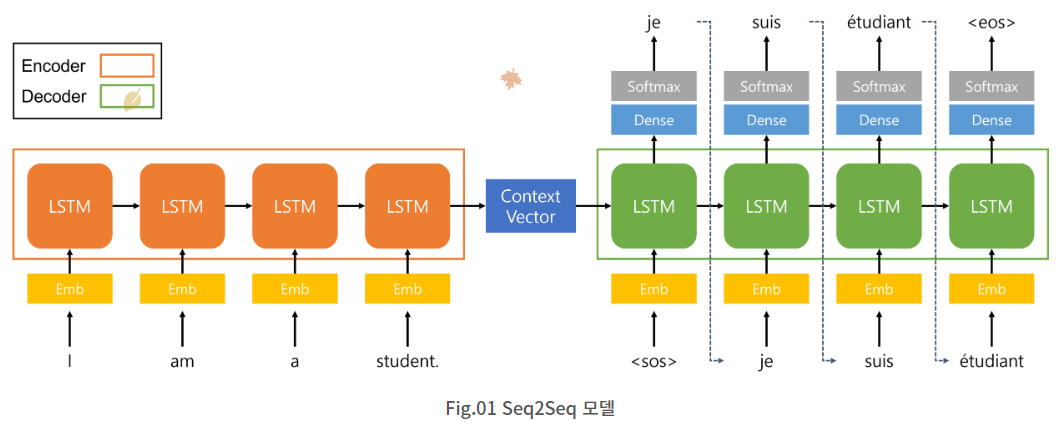

# 예제1

In [2]:
import numpy as np
import torch
import torch.nn as nn

In [3]:
n_step = 5 # 글자의 최대 길이
n_hidden = 128

## 데이터

### 데이터 생성

In [4]:
seq_data = [['man', 'women'], ['black', 'white'], ['king', 'queen'], ['girl', 'boy'], ['up', 'down'], ['high', 'low']]
np.array(seq_data).shape

(6, 2)

In [ ]:
batch_size = len(seq_data)
batch_size

6

### 데이터 토큰화

In [ ]:
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz'] # S(시작), E(끝), P(패딩)
len(char_arr)

29

### 데이터 사전

In [ ]:
num_dic = {n: i for i, n in enumerate(char_arr)}
n_class = len(num_dic)
n_class

29

In [ ]:
char_arr[5], num_dic['c']

('c', 5)

## 학습 데이터

### 학습 데이터 생성

In [ ]:
def make_batch():
    input_batch, output_batch, target_batch = [], [], []

    for seq in seq_data:
        for i in range(2):
            seq[i] = seq[i] + 'P' * (n_step - len(seq[i])) # P(2): 패딩

        input = [num_dic[n] for n in seq[0]]
        output = [num_dic[n] for n in ('S' + seq[1])] # S(0): 시작
        target = [num_dic[n] for n in (seq[1] + 'E')] # E(1): 끝

        input_batch.append(np.eye(n_class)[input]) # one-hot
        output_batch.append(np.eye(n_class)[output]) # one-hot
        target_batch.append(target) # not one-hot

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

In [ ]:
input_batch, output_batch, target_batch = make_batch()

# input_batch: (batch_size(데이터 수), input_size(최대 글자 수), embedding_size(원핫인코딩 수))
# output_batch: (batch_size(데이터 수), input_size(1(S) + 최대 글자 수), embedding_size(원핫인코딩 수))
# target_batch: ((batch_size(데이터 수), input_size(1(S) + 최대 글자 수))
input_batch.shape, output_batch.shape, target_batch.shape

<ipython-input-8-9685e5fb509e>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)


(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

### 디버깅

In [ ]:
seq_data

[['manPP', 'women'],
 ['black', 'white'],
 ['kingP', 'queen'],
 ['girlP', 'boyPP'],
 ['upPPP', 'downP'],
 ['highP', 'lowPP']]

In [ ]:
# 1. 데이터 구조 파악 : 리스트1 , 리스트2
# 2. 리스트2에서 가장 큰 길이를 찾아서 새로운 리스트3에 담음
# 2-1. 리스트3: 리스트2에서 가장 큰 길이들이 모임
# 3. 리스트3에서 가장 큰 수 찾음
tmp = [ len(row[0]) if len(row[0]) > len(row[1]) else len(row[1]) for row in seq_data ]
tmp

[5, 5, 5, 5, 5, 5]

In [ ]:
max(tmp)

5

In [ ]:
n_step # 글자의 최대 길이

5

In [ ]:
for seq in [['man', 'women']]:
    for i in range(2):
        seq[i] = seq[i] + 'P' * (n_step - len(seq[i])) # P(2): 패딩

    input = [num_dic[n] for n in seq[0]]
    output = [num_dic[n] for n in ('S' + seq[1])] # S(0): 시작
    target = [num_dic[n] for n in (seq[1] + 'E')] # E(1): 끝

    break

In [ ]:
seq

['manPP', 'women']

In [ ]:
input

[15, 3, 16, 2, 2]

In [ ]:
output

[0, 25, 17, 15, 7, 16]

In [ ]:
target

[25, 17, 15, 7, 16, 1]

In [ ]:
len(np.eye(n_class)[input]) # 5개 글자!!!

5

In [ ]:
np.eye(n_class)[input][0] # 글자별 원핫인코딩!!

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Seq2Seq 모델 생성

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super(Seq2Seq, self).__init__()

        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 인코딩
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 디코딩
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, enc_input, enc_hidden, dec_input):
        enc_input = enc_input.transpose(0, 1) # enc_input: [input_size, batch_size, embedding_size]
        dec_input = dec_input.transpose(0, 1) # dec_input: [input_size, batch_size, embedding_size]

        # enc_states : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        _, enc_states = self.enc_cell(enc_input, enc_hidden)

        # outputs : [max_len+1(=6), batch_size, num_directions(=1) * n_hidden(=128)]
        outputs, _ = self.dec_cell(dec_input, enc_states)

        _outputs = outputs.transpose(0, 1) # _outputs (batch_size, input_size(1(E) + 최대 글자 수), n_hidden)
        pred = self.fc(_outputs) # pred : [batch_size, max_len+1(=6), n_class]
        return pred

### 디버깅

In [ ]:
input_batch, output_batch, target_batch = make_batch()
# input_batch: (batch_size(데이터 수), input_size(최대 글자 수), embedding_size(원핫인코딩 수))
# output_batch: (batch_size(데이터 수), input_size(1(S) + 최대 글자 수), embedding_size(원핫인코딩 수))
# target_batch: ((batch_size(데이터 수), input_size(1(E) + 최대 글자 수))
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

In [ ]:
n_class, n_hidden

(29, 128)

In [ ]:
enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
fc = nn.Linear(n_hidden, n_class)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
enc_input = input_batch.transpose(0, 1)
# enc_input: (input_size(최대 글자 수), batch_size(데이터 수), embedding_size(원핫인코딩 수))
enc_input.shape

torch.Size([5, 6, 29])

In [ ]:
dec_input = output_batch.transpose(0, 1)
# dec_input: (input_size(1(S) + 최대 글자 수), batch_size(데이터 수), embedding_size(원핫인코딩 수))
dec_input.shape

torch.Size([6, 6, 29])

In [ ]:
enc_hidden = torch.zeros(1, batch_size, n_hidden) # 초기값
enc_hidden.shape

torch.Size([1, 6, 128])

In [ ]:
_, enc_states = enc_cell(enc_input, enc_hidden)
_.shape, enc_states.shape # enc_states (layer_size * num_directions, batch_size, n_hidden)

(torch.Size([5, 6, 128]), torch.Size([1, 6, 128]))

In [ ]:
outputs, _ = dec_cell(dec_input, enc_states)
outputs.shape, _.shape # outputs (input_size(1(E) + 최대 글자 수), batch_size, n_hidden)

(torch.Size([6, 6, 128]), torch.Size([1, 6, 128]))

In [ ]:
_outputs = outputs.transpose(0, 1) # outputs (batch_size, input_size(1(E) + 최대 글자 수), n_hidden)

In [ ]:
pred = fc(_outputs)
pred.shape # outputs (batch_size, input_size(1(E) + 최대 글자 수), embedding_size)

torch.Size([6, 6, 29])

## 학습

In [ ]:
model = Seq2Seq()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

input_batch, output_batch, target_batch = make_batch()

In [ ]:
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

In [ ]:
for epoch in range(5000):
    hidden = torch.zeros(1, batch_size, n_hidden)
    output = model(input_batch, hidden, output_batch)
    loss = 0
    for i in range(0, len(target_batch)):
        loss += criterion(output[i], target_batch[i])
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 0.003359
Epoch: 2000 cost = 0.000930
Epoch: 3000 cost = 0.000395
Epoch: 4000 cost = 0.000198
Epoch: 5000 cost = 0.000107


## 테스트

In [ ]:
def make_testbatch(input_word):
    input_batch, output_batch = [], []

    input_w = input_word + 'P' * (n_step - len(input_word)) # P: 패딩 추가
    input = [num_dic[n] for n in input_w]
    output_w = 'S' + 'P' * n_step
    print(f'input_w: {input_w} / output_w: {output_w}')
    output = [num_dic[n] for n in output_w] # S와 P로 output 구성

    input_batch = np.eye(n_class)[input]
    output_batch = np.eye(n_class)[output]

    return torch.FloatTensor(input_batch).unsqueeze(0), torch.FloatTensor(output_batch).unsqueeze(0)

In [ ]:
n_step

5

In [ ]:
input_batch, output_batch = make_testbatch('black')
input_batch.shape, output_batch.shape

input_w: black / output_w: SPPPPP


(torch.Size([1, 5, 29]), torch.Size([1, 6, 29]))

In [ ]:
input_batch, output_batch = make_testbatch('upp')
input_batch.shape, output_batch.shape

input_w: uppPP / output_w: SPPPPP


(torch.Size([1, 5, 29]), torch.Size([1, 6, 29]))

In [ ]:
hidden = torch.zeros(1, 1, n_hidden)
hidden.shape

torch.Size([1, 1, 128])

In [ ]:
output = model(input_batch, hidden, output_batch)
output.shape

torch.Size([1, 6, 29])

In [ ]:
output[0][0] # max: 16.0384

tensor([-0.8553,  0.5574, -6.7259, -0.4536,  2.4388, -0.0677, 15.4211, -1.4463,
        -0.7239, -0.6468,  0.1138, -3.1652, -0.5489, -0.6308,  4.0963, -1.4219,
        -3.9418,  0.6089, -0.6313,  2.7930, -0.5754, -0.8456,  1.6900,  0.8206,
        -0.3669,  3.6040, -1.0437, -3.3826, -0.0784],
       grad_fn=<SelectBackward0>)

In [ ]:
output.data.max(2, keepdim=True) # values: 최대값, indices: 인덱스값

torch.return_types.max(
values=tensor([[[15.4211],
         [15.4521],
         [15.2835],
         [13.5590],
         [14.6365],
         [14.9730]]]),
indices=tensor([[[ 6],
         [17],
         [25],
         [16],
         [ 2],
         [ 1]]]))

In [ ]:
predict = output.data.max(2, keepdim=True)[1]
predict.shape

torch.Size([1, 6, 1])

In [ ]:
predict

tensor([[[ 6],
         [17],
         [25],
         [16],
         [ 2],
         [ 1]]])

In [ ]:
decoded = [char_arr[i] for i in predict[0]]
decoded # E: 문장의 끝을 나타냄, P: 패딩

['d', 'o', 'w', 'n', 'P', 'E']

In [ ]:
# Test
def translate(word):
    input_batch, output_batch = make_testbatch(word)

    # make hidden shape [num_layers * num_directions, batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)
    output = model(input_batch, hidden, output_batch)
    # output : [max_len+1(=6), batch_size(=1), n_class]

    predict = output.data.max(2, keepdim=True)[1] # select n_class dimension
    decoded = [char_arr[i] for i in predict[0]]
    end = decoded.index('E')
    translated = ''.join(decoded[:end])

    return translated.replace('P', '')

In [ ]:
print('test')
print('man ->', translate('man'))
print('mans ->', translate('mans'))
print('king ->', translate('king'))
print('black ->', translate('black'))
print('upp ->', translate('upp'))

test
input_w: manPP / output_w: SPPPPP
man -> women
input_w: mansP / output_w: SPPPPP
mans -> women
input_w: kingP / output_w: SPPPPP
king -> queen
input_w: black / output_w: SPPPPP
black -> white
input_w: uppPP / output_w: SPPPPP
upp -> down


# 예제2

In [ ]:
import numpy as np
import torch
import torch.nn as nn

## 데이터 생성

In [ ]:
seq_data = [['man', 'women'], ['black', 'white'], ['king', 'queen'], ['girl', 'boy'], ['up', 'down'], ['high', 'low']]
np.array(seq_data).shape

(6, 2)

In [ ]:
len_list = [len(data[0]) if len(data[0]) > len(data[1]) else len(data[1]) for data in seq_data]
len_list

[5, 5, 5, 4, 4, 4]

In [ ]:
max(len_list)

5

## 데이터 전처리

### 토큰화

In [ ]:
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz'] # S(시작), E(끝), P(패딩)
len(char_arr)

29

### 데이터 사전

In [ ]:
num_dic = {n: i for i, n in enumerate(char_arr)}
n_class = len(num_dic)
n_class

29

## Dataset 생성

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class DatasetVer2(Dataset):
  def __init__(self, datas):
    super().__init__()
    self.max_step = self.__get_max_step(datas)
    self.enc_inputs, self.dec_inputs, self.targets = self.__preprocessing(self.__add_padding(datas))

  def __get_max_step(self, datas):
    len_list = [len(data[0]) if len(data[0]) > len(data[1]) else len(data[1]) for data in datas]
    return max(len_list)

  def __add_padding(self, datas):
    for data in datas:
      for i in range(2):
        data[i] = data[i] + 'P'*(self.max_step - len(data[i]))

    return datas

  def __preprocessing(self, datas):
    enc_inputs, dec_inputs, targets = [], [], []

    for data in datas:
      input = [num_dic[n] for n in seq[0]]
      output = [num_dic[n] for n in ('S' + seq[1])] # S(0): 시작
      target = [num_dic[n] for n in (seq[1] + 'E')] # E(1): 끝

      enc_inputs.append(input)
      dec_inputs.append(output)
      targets.append(target)

    return torch.tensor(enc_inputs, dtype=torch.int64), torch.tensor(dec_inputs, dtype=torch.int64), torch.tensor(targets, dtype=torch.int64)

  def __len__(self):
    return len(self.enc_inputs)

  def __getitem__(self, index):
    return self.enc_inputs[index], self.dec_inputs[index], self.targets[index]


In [ ]:
len(seq_data)

6

In [ ]:
dt = DatasetVer2(seq_data)

In [ ]:
dt.max_step

5

In [ ]:
len(dt)

6

In [ ]:
enc_input, dec_input, target = dt[0]

enc_input.shape, dec_input.shape, target.shape

(torch.Size([5]), torch.Size([6]), torch.Size([6]))

## DataLoader 생성

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
dl = DataLoader(dt, batch_size=3, shuffle=True)

In [ ]:
len(dl)

2

In [ ]:
enc_input, dec_input, target = next(iter(dl))

enc_input.shape, dec_input.shape, target.shape

(torch.Size([3, 5]), torch.Size([3, 6]), torch.Size([3, 6]))

## Model 생성

In [ ]:
class Encoding(nn.Module):
  def __init__(self, size_vocab, embedding_size, hidden_size):
    super().__init__()

    self.hidden_size = hidden_size
    self.embed = nn.Embedding(size_vocab, embedding_size)
    self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size)

  def forward(self, x):
    init_hidden = torch.zeros(1, x.shape[0], self.hidden_size) # 초기값
    emb_out = self.embed(x)
    input_rnn = emb_out.transpose(0, 1)

    return self.rnn(input_rnn, init_hidden)

- 디버깅

In [ ]:
enc_input.shape, dec_input.shape, target.shape

(torch.Size([3, 5]), torch.Size([3, 6]), torch.Size([3, 6]))

In [ ]:
size_vocab = n_class
embedding_size = 128
hidden_size = 128

In [ ]:
embed = nn.Embedding(size_vocab, embedding_size)
embed

Embedding(29, 128)

In [ ]:
emb_out = embed(enc_input)
emb_out.shape

torch.Size([3, 5, 128])

In [ ]:
input_rnn = emb_out.transpose(0, 1)
input_rnn.shape

torch.Size([5, 3, 128])

In [ ]:
init_hidden = torch.zeros(1, enc_input.shape[0], hidden_size)
init_hidden.shape

torch.Size([1, 3, 128])

In [ ]:
rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size)
rnn

RNN(128, 128)

In [ ]:
out, hidden = rnn(input_rnn, init_hidden)
out.shape, hidden.shape

(torch.Size([5, 3, 128]), torch.Size([1, 3, 128]))

In [ ]:
class Decoding(nn.Module):
  def __init__(self, size_vocab, embedding_size, hidden_size):
    super().__init__()

    self.embed = nn.Embedding(size_vocab, embedding_size)
    self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size)
    self.fc = nn.Linear(hidden_size, embedding_size)

  def forward(self, x, context_vector):
    emb_out = self.embed(x)
    input_rnn = emb_out.transpose(0, 1)

    out_rnn, _ = self.rnn(input_rnn, context_vector)
    out_rnn = out_rnn.transpose(0, 1)
    return self.fc(out_rnn)

In [ ]:
class Seq2SeqVer2(nn.Module):
  def __init__(self, size_vocab, embedding_size, hidden_size):
    super().__init__()

    self.enc_layer = Encoding(size_vocab, embedding_size, hidden_size)
    self.dec_layer = Decoding(size_vocab, embedding_size, hidden_size)

  def forward(self, enc_input, dec_input):
    _, enc_hidden = self.enc_layer(enc_input)

    pred = self.dec_layer(dec_input, enc_hidden)
    return pred

### 디버깅

In [ ]:
size_vocab = n_class
embedding_size = 128
hidden_size = 128

In [ ]:
model = Seq2SeqVer2(n_class, embedding_size, hidden_size)

In [ ]:
enc_input.shape, dec_input.shape, target.shape

(torch.Size([3, 5]), torch.Size([3, 6]), torch.Size([3, 6]))

In [ ]:
target[0].shape

torch.Size([6])

In [ ]:
pred = model(enc_input, dec_input)
pred.shape

torch.Size([3, 6, 128])

In [ ]:
pred[0].shape

torch.Size([6, 128])

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
loss = criterion(pred[0], target[0])

In [ ]:
loss

tensor(4.5777, grad_fn=<NllLossBackward0>)

## 엔진

In [ ]:
def train_step(model, dataloader, loss_fn, optimizer, device='cpu'):
  model.train()
  epoch_loss = 0
  for enc_input, dec_input, target in dataloader:
    pred = model(enc_input.to(device), dec_input.to(device))

    for i in range(0, len(pred)):
      loss = loss_fn(pred[i], target[i])
      epoch_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return epoch_loss

## 학습

In [ ]:
model = Seq2SeqVer2(n_class, embedding_size, hidden_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
dt = DatasetVer2(seq_data)
dl = DataLoader(dt, batch_size=3, shuffle=True)

In [ ]:
for epoch in range(5000):
  epoch_loss = train_step(model, dl, criterion, optimizer)
  if (epoch + 1) % 1000 == 0:
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(epoch_loss))

Epoch: 1000 cost = 0.000819
Epoch: 2000 cost = 0.000190
Epoch: 3000 cost = 0.000059
Epoch: 4000 cost = 0.000021
Epoch: 5000 cost = 0.000008
